In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import random

In [2]:
# We will use a dataset with circa 1 million transactions to segments customers
# First we load our dataset
transactions = pd.read_csv('C:/Users/Can/Desktop/cv ck/projeler/bank customer segmentation/bank_transactions.csv')

In [3]:
# Quick look at our dataset
transactions.head(5)

# TransactionID: Unique key for each transaction, we can convert this to index
# CustomerID: Unique key for each customer
# CustomerDOB: Date of birth, we can use this to calculate customer age and drop this
# CustGender: Relevant for segmentation
# CustLocation : Relevant for segmentation
# CustAccountBalance: We can have groups based on account balance 
# TransactionDate: We can observe what point in history customers made the most transactions
# TransactionTime: Time of day, we can observe which time of day has the most frequent transactions
# TransactionAmount: Also a very relevant datapoint

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
# We should first preprocess and transform our data before starting our analysis
# Checking data types
print(transactions.dtypes)

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object


In [5]:
# Convert CustomerDOB,TransactionDate to datetime format
transactions['CustomerDOB'] = pd.to_datetime(transactions['CustomerDOB'], format='%d/%m/%y', errors='coerce', yearfirst=True)
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], format='%d/%m/%y', errors='coerce')
# Extract time component from TransactionTime in a better format
transactions['TransactionTime'] = pd.to_datetime(transactions['TransactionTime'].astype(str).str.zfill(6), format='%H%M%S').dt.time

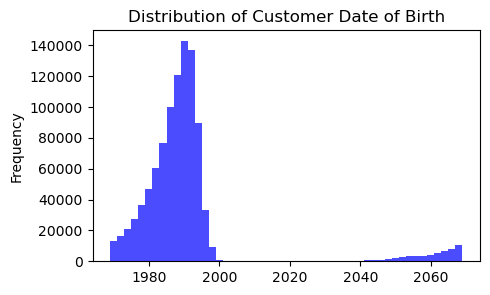

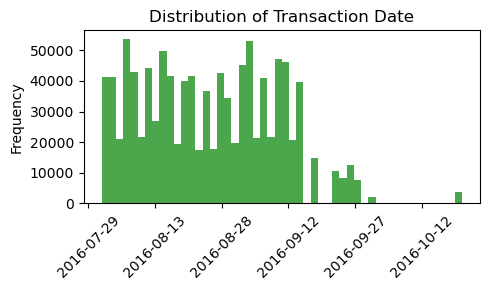

In [6]:
# Distribution of CustomerDOB
plt.figure(figsize=(5, 3))
plt.hist(transactions['CustomerDOB'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Customer Date of Birth')
plt.ylabel('Frequency')
plt.show()

# Distribution of TransactionDate
plt.figure(figsize=(5, 3))
plt.hist(transactions['TransactionDate'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Transaction Date')
plt.ylabel('Frequency')

# Date format for x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Display ticks every 3 months

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

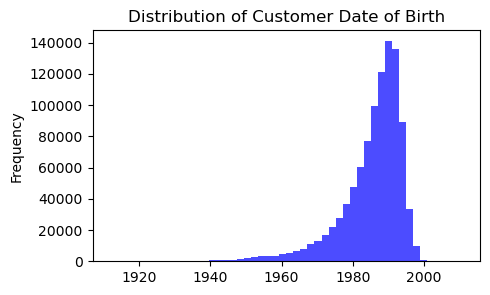

In [7]:
# Seems we have an issue converting when converting some birth dates e.g. 1968-is interpreted as 2068
# To fix this, we will subtract 100 years for birth dates after a cutoff date

# Subtract 100 years from CustomerDOB values if they are greater than 2010
transactions['CustomerDOB'] = pd.to_datetime(transactions['CustomerDOB'], format='%Y-%m-%d', errors='coerce')
transactions.loc[transactions['CustomerDOB'].dt.year > 2010, 'CustomerDOB'] -= pd.DateOffset(years=100)

# Verifying the fix
plt.figure(figsize=(5, 3))
plt.hist(transactions['CustomerDOB'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Customer Date of Birth')
plt.ylabel('Frequency')
plt.show()

In [8]:
# The issue seems to be fixed
# Lets check our dataset for other issues, namely missing values
missing_values = transactions.isna().sum()

print("Number of missing values in each column:")
print(missing_values)

# It seems still some issues with DOB - we can input some random values around the mean DOB
# The other missing values are insignificant taking into account the size of our data

Number of missing values in each column:
TransactionID                  0
CustomerID                     0
CustomerDOB                60736
CustGender                  1100
CustLocation                 151
CustAccountBalance          2369
TransactionDate                0
TransactionTime                0
TransactionAmount (INR)        0
dtype: int64


In [9]:
# Replacing missing DOB values
mean_dob = transactions['CustomerDOB'][transactions['CustomerDOB'].notna()].mean()

# Range of years - arbitrary
random_years = 14

# Calculate the number of days in specified year range
days_in_range = random_years * 365

# Generating a random offset in days for each missing DOB
random_offsets = [pd.Timedelta(random.randint(-days_in_range, days_in_range), unit='D') for _ in range(len(transactions))]

# List to store the randomized DOB values
filled_dob = []

# Adding random offsets to the mean DOB
for offset in random_offsets:
    filled_dob.append(mean_dob + offset)

# Replacing missing DOB values with the randomized DOB
transactions['CustomerDOB'].fillna(pd.Series(filled_dob), inplace=True)

# Verify the changes
print("Updated DataFrame:")
print(transactions.head())

Updated DataFrame:
  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053  1994-01-10          F   JAMSHEDPUR   
1            T2   C2142763  1957-04-04          M      JHAJJAR   
2            T3   C4417068  1996-11-26          F       MUMBAI   
3            T4   C5342380  1973-09-14          F       MUMBAI   
4            T5   C9031234  1988-03-24          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate TransactionTime  TransactionAmount (INR)  
0            17819.05      2016-08-02        14:32:07                     25.0  
1             2270.69      2016-08-02        14:18:58                  27999.0  
2            17874.44      2016-08-02        14:27:12                    459.0  
3           866503.21      2016-08-02        14:27:14                   2060.0  
4             6714.43      2016-08-02        18:11:56                   1762.5  


In [10]:
# Define a reference date for calculating ages - since the dataset is somewhat dated
reference_date = pd.to_datetime('2018-06-06')

# Calculate age based on the reference date
transactions['Age'] = (reference_date.year - transactions['CustomerDOB'].dt.year) - ((reference_date.month < transactions['CustomerDOB'].dt.month) | ((reference_date.month == transactions['CustomerDOB'].dt.month) & (reference_date.day < transactions['CustomerDOB'].dt.day)))

print("\nData types:")
print(transactions.dtypes)


Data types:
TransactionID                      object
CustomerID                         object
CustomerDOB                datetime64[ns]
CustGender                         object
CustLocation                       object
CustAccountBalance                float64
TransactionDate            datetime64[ns]
TransactionTime                    object
TransactionAmount (INR)           float64
Age                                 int32
dtype: object


In [11]:
# Now we can drop DOB column since we already calculated the age. We can also set the transaction ID as index.
transactions.set_index('TransactionID', inplace=True)
transactions.drop(columns=['CustomerDOB'], inplace=True)

# Verify changes
print("Updated DataFrame:")
transactions.head()

Updated DataFrame:


,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
TransactionID,,,,,,,,
T1,C5841053,F,JAMSHEDPUR,17819.05,2016-08-02,14:32:07,25.0,24
T2,C2142763,M,JHAJJAR,2270.69,2016-08-02,14:18:58,27999.0,61
T3,C4417068,F,MUMBAI,17874.44,2016-08-02,14:27:12,459.0,21
T4,C5342380,F,MUMBAI,866503.21,2016-08-02,14:27:14,2060.0,44
T5,C9031234,F,NAVI MUMBAI,6714.43,2016-08-02,18:11:56,1762.5,30


In [12]:
# Number of unique values in each column
unique_counts = transactions.nunique()

print("Number of unique values in each column:")
print(unique_counts)

Number of unique values in each column:
CustomerID                 884265
CustGender                      3
CustLocation                 9355
CustAccountBalance         161328
TransactionDate                55
TransactionTime             81918
TransactionAmount (INR)     93024
Age                            97
dtype: int64


In [13]:
# Aggregation: Count of Customers in Each Location
location_counts = transactions.groupby('CustLocation')['CustomerID'].nunique().sort_values(ascending=False)

# Subgrouping: Count of Males and Females in Each Location
gender_location_counts = transactions.groupby(['CustLocation', 'CustGender'])['CustomerID'].nunique().unstack(fill_value=0)
gender_location_counts_sorted = gender_location_counts.sort_values(by=['M', 'F'], ascending=False)

# Print the results
print("Count of Customers in Each Location (Top 10):")
print(location_counts.head(15))  
print("\nCount of Males and Females in Each Location (Top 10):")
print(gender_location_counts_sorted.head(15)) 

Count of Customers in Each Location (Top 10):
CustLocation
MUMBAI         101729
NEW DELHI       83564
BANGALORE       80347
GURGAON         72856
DELHI           70067
NOIDA           32570
CHENNAI         29823
PUNE            25710
HYDERABAD       22929
THANE           21404
KOLKATA         19874
GHAZIABAD       15769
NAVI MUMBAI     13036
AHMEDABAD       12229
FARIDABAD       11280
Name: CustomerID, dtype: int64

Count of Males and Females in Each Location (Top 10):
CustGender        F      M  T
CustLocation                 
MUMBAI        32413  69267  0
NEW DELHI     24278  59764  0
BANGALORE     23917  56860  0
DELHI         21807  48644  0
GURGAON       24933  48322  0
NOIDA          9276  23364  0
CHENNAI        7204  22668  1
PUNE           6590  19149  0
HYDERABAD      6233  16724  0
THANE          5595  15807  0
KOLKATA        6418  13471  0
GHAZIABAD      4291  11498  0
NAVI MUMBAI    3504   9493  0
AHMEDABAD      2976   9213  0
FARIDABAD      2863   8427  0


<Figure size 1000x400 with 0 Axes>

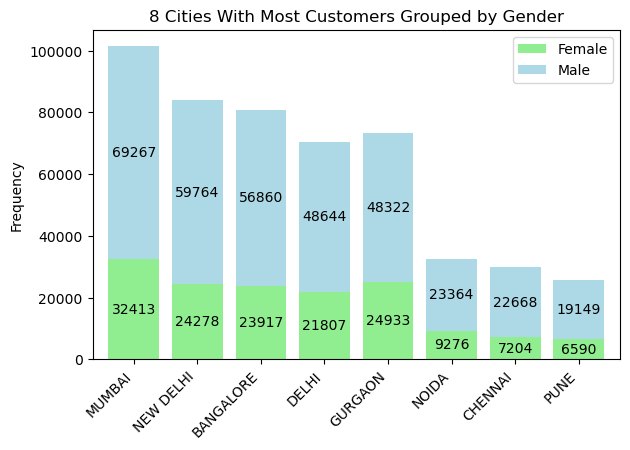

In [14]:
gender_location_counts_sorted.dropna(inplace=True)

# Plot count of males and females in each locations
plt.figure(figsize=(10, 4))
ax = gender_location_counts_sorted[['F', 'M']].head(8).plot(kind='bar', stacked=True, color=['lightgreen', 'lightblue'], width=0.8)

for bar in ax.containers:
    ax.bar_label(bar, label_type='center')

plt.title('8 Cities With Most Customers Grouped by Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(['Female', 'Male'])
plt.tight_layout()
ax.set_xlabel("")
plt.show()

#The top 5 cities have most of the bank's customer base

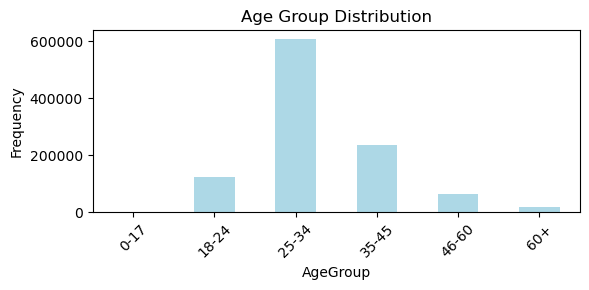

In [15]:
# Define age groups
age_bins = [0, 18, 25, 35, 46, 60, 120]
age_labels = ['0-17', '18-24', '25-34', '35-45', '46-60', '60+'] 

# Add AgeGroup column to the DataFrame
transactions['AgeGroup'] = pd.cut(transactions['Age'], bins=age_bins, labels=age_labels, right=False)

# Count occurrences of each age group
age_group_counts = transactions['AgeGroup'].value_counts().sort_index()

# Plot age group distribution
plt.figure(figsize=(6, 3))
age_group_counts.plot(kind='bar', color='lightblue')
plt.title('Age Group Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
ax.set_xlabel("")
plt.show()

#25-34 is the dominant age group, followed by 35-45

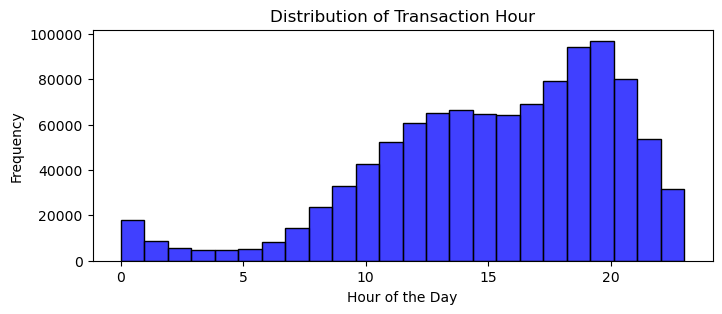

In [16]:
# Evaluating transaction times
transactions['TransactionTime'] = pd.to_datetime(transactions['TransactionTime'], format='%H:%M:%S')

# Extract the hour component from TransactionTime
transaction_hour = transactions['TransactionTime'].dt.hour

# Plot the distribution of transaction hour
plt.figure(figsize=(8, 3))
sns.histplot(transaction_hour, bins=24, color='blue')
plt.title('Distribution of Transaction Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

# We can see that transactions are distributed somewhat uniform during the day, peaking around 5-7 p.m.

In [17]:
# Lets evaluate the numerical variables
pd.options.display.float_format = '{:,.2f}'.format

# Summary statistics for specific numerical columns
numerical_columns = ['CustAccountBalance', 'TransactionAmount (INR)', 'Age']
summary_stats = transactions[numerical_columns].describe()
summary_stats

# Average balance is 115k INR
# Average transaction amount is 1574 INR
# We can use the values in the summary to estimate bins and cutoffs for our distribution plots

,CustAccountBalance,TransactionAmount (INR),Age
count,"1,046,198.00","1,048,567.00","1,048,567.00"
mean,"115,403.54","1,574.34",32.46
std,"846,485.38","6,574.74",8.76
min,0.00,0.00,7.00
25%,"4,721.76",161.00,27.00
50%,"16,792.18",459.03,30.00
75%,"57,657.36","1,200.00",36.00
max,"115,035,495.10","1,560,034.99",106.00


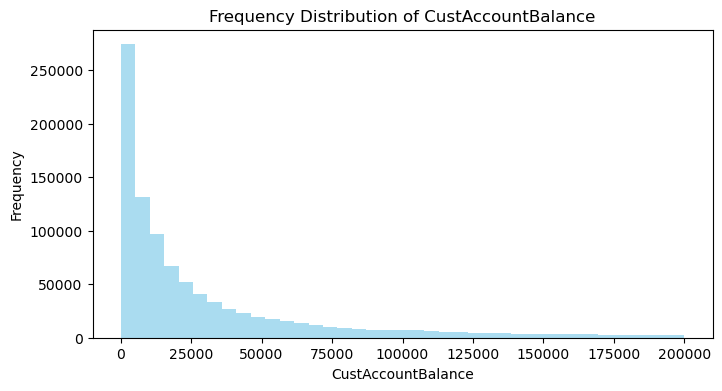

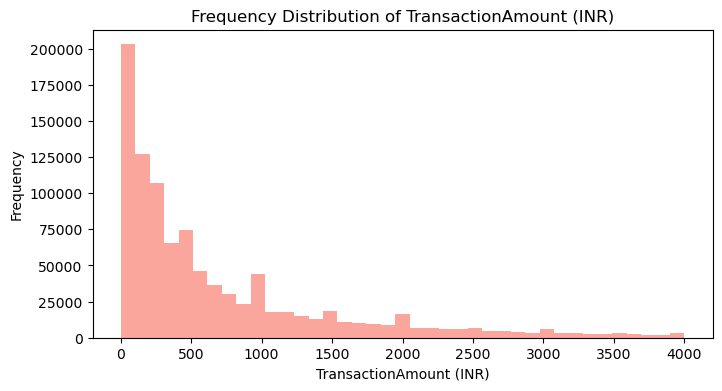

In [18]:
# Define bin edges for CustAccountBalance and TransactionAmount (INR)
balance_bins = np.linspace(0, 200000, 40)  
amount_bins = np.linspace(0, 4000, 40)      

# Frequency distribution for CustAccountBalance
plt.figure(figsize=(8, 4))
plt.hist(transactions['CustAccountBalance'], bins=balance_bins, color='skyblue', alpha=0.7)
plt.title('Frequency Distribution of CustAccountBalance')
plt.xlabel('CustAccountBalance')
plt.ylabel('Frequency')
plt.show()

# Frequency distribution for TransactionAmount (INR)
plt.figure(figsize=(8, 4))
plt.hist(transactions['TransactionAmount (INR)'], bins=amount_bins, color='salmon', alpha=0.7)
plt.title('Frequency Distribution of TransactionAmount (INR)')
plt.xlabel('TransactionAmount (INR)')
plt.ylabel('Frequency')
plt.show()

In [19]:
# We have made some observations regarding the banks clients. To segment customers, we should also evaluate 
# how many transactions each customer has made, and how much the customer has spent in total in new columns.

# Group transactions by CustomerID and aggregate transaction amount
customer_transactions = transactions.groupby('CustomerID').agg({'TransactionAmount (INR)': ['sum', 'count']})

# Rename columns
customer_transactions.columns = ['TotalSpent', 'NumTransactions']

# Reset index to make CustomerID a regular column
customer_transactions.reset_index(inplace=True)

# Display the resulting DataFrame
customer_transactions.head()

,CustomerID,TotalSpent,NumTransactions
0,C1010011,"5,106.00",2
1,C1010012,"1,499.00",1
2,C1010014,"1,455.00",2
3,C1010018,30.00,1
4,C1010024,"5,000.00",1


In [20]:
# We can use merge this new dataframe with relevant info from our transactions dataframe.
# Most relevant for us are gender, location, account balance, and age. Also we will Transaction columns for some issue fixes
transactions.reset_index(inplace=True)

# Select relevant columns from the transactions DataFrame
relevant_info = transactions[['CustomerID', 'CustGender', 'CustLocation', 'CustAccountBalance', 'Age','TransactionID','TransactionAmount (INR)']]

# Merge customer_transactions with relevant_info on CustomerID
merged_data = pd.merge(customer_transactions, relevant_info, on='CustomerID', how='inner')

# Display the resulting merged DataFrame
merged_data.head(12)

# Here we notice that some customerID's were given to multiple customers. We should give new customerID's to these customers.

,CustomerID,TotalSpent,NumTransactions,CustGender,CustLocation,CustAccountBalance,Age,TransactionID,TransactionAmount (INR)
0,C1010011,"5,106.00",2,F,NOIDA,"32,500.73",25,T33671,"4,750.00"
1,C1010011,"5,106.00",2,M,NEW DELHI,"120,180.54",34,T173509,356.00
2,C1010012,"1,499.00",1,M,MUMBAI,"24,204.49",23,T363022,"1,499.00"
3,C1010014,"1,455.00",2,F,MUMBAI,"38,377.14",26,T89544,"1,205.00"
4,C1010014,"1,455.00",2,M,MUMBAI,"161,848.76",33,T251648,250.00
5,C1010018,30.00,1,F,CHAMPARAN,496.18,28,T971994,30.00
6,C1010024,"5,000.00",1,M,KOLKATA,"87,058.65",52,T401396,"5,000.00"
7,C1010028,557.00,1,F,DELHI,"296,828.37",29,T642232,557.00
8,C1010031,"1,864.00",2,M,VAPI,"1,754.10",33,T50881,404.00
9,C1010031,"1,864.00",2,M,TRICHY,"8,646.21",29,T169855,"1,460.00"


In [21]:
# Sort the DataFrame by the 'NumTransactions' and 'CustomerID' columns
merged_data_sorted = merged_data.sort_values(by=['NumTransactions', 'CustomerID'], ascending=[False, True])

# Display the sorted DataFrame
merged_data_sorted.head(12)

# It also seems there is no actual customer that did multiple transactions in the dataset, these are all different customers

,CustomerID,TotalSpent,NumTransactions,CustGender,CustLocation,CustAccountBalance,Age,TransactionID,TransactionAmount (INR)
5651,C1026833,"3,336.00",6,M,BARABANKI,"6,445.23",24,T216046,4.00
5652,C1026833,"3,336.00",6,M,AMBALA CANTT,"5,002.28",43,T454271,846.00
5653,C1026833,"3,336.00",6,M,WARANGAL,"5,118.79",31,T483421,871.00
5654,C1026833,"3,336.00",6,F,VISAKHAPATNAM,"3,242.42",23,T657242,"1,245.00"
5655,C1026833,"3,336.00",6,M,TIRUVANNAMALAI,"118,800.14",30,T702617,320.00
5656,C1026833,"3,336.00",6,M,NAGPUR,"33,193.87",28,T776106,50.00
14136,C1113684,"37,873.00",6,M,UDHAMPUR,9.85,36,T466366,477.00
14137,C1113684,"37,873.00",6,F,BANGALORE,"17,797.66",31,T530017,348.00
14138,C1113684,"37,873.00",6,M,CHENNAI,"37,657.39",29,T568646,"34,980.00"
14139,C1113684,"37,873.00",6,M,SECUNDERABAD,"1,345.18",28,T658168,40.00


In [22]:
# We will drop CustomerID, TotalSpent, and NumTransactions since they were calculated incorrectly
# We will use index as new customer ID, then calculate TotalSpent and NumTransactions again

merged_data.drop(columns=['CustomerID', 'TotalSpent', 'NumTransactions'], inplace=True)

# Reset the index and rename it to CustomerID
merged_data.reset_index(inplace=True)
merged_data.rename(columns={'index': 'CustomerID'}, inplace=True)

merged_data.head()

,CustomerID,CustGender,CustLocation,CustAccountBalance,Age,TransactionID,TransactionAmount (INR)
0,0,F,NOIDA,"32,500.73",25,T33671,"4,750.00"
1,1,M,NEW DELHI,"120,180.54",34,T173509,356.00
2,2,M,MUMBAI,"24,204.49",23,T363022,"1,499.00"
3,3,F,MUMBAI,"38,377.14",26,T89544,"1,205.00"
4,4,M,MUMBAI,"161,848.76",33,T251648,250.00


In [23]:
# Ok we can now again calculate group by CustomerID to calculate the desired new columns
customer_transactions2 = merged_data.groupby('CustomerID').agg({'TransactionAmount (INR)': ['sum', 'count']})
customer_transactions2.columns = ['TotalSpent', 'NumTransactions']
customer_transactions2.head()

,TotalSpent,NumTransactions
CustomerID,,
0,"4,750.00",1
1,356.00,1
2,"1,499.00",1
3,"1,205.00",1
4,250.00,1


In [24]:
# Merge the customer_transactions2 DataFrame with the merged_data DataFrame
merged_data = merged_data.merge(customer_transactions2, on='CustomerID', how='left')

# Display the updated DataFrame
merged_data.head()

,CustomerID,CustGender,CustLocation,CustAccountBalance,Age,TransactionID,TransactionAmount (INR),TotalSpent,NumTransactions
0,0,F,NOIDA,"32,500.73",25,T33671,"4,750.00","4,750.00",1
1,1,M,NEW DELHI,"120,180.54",34,T173509,356.00,356.00,1
2,2,M,MUMBAI,"24,204.49",23,T363022,"1,499.00","1,499.00",1
3,3,F,MUMBAI,"38,377.14",26,T89544,"1,205.00","1,205.00",1
4,4,M,MUMBAI,"161,848.76",33,T251648,250.00,250.00,1


In [25]:
# Check if each CustomerID is unique
is_unique_customer_id = merged_data['CustomerID'].nunique() == len(merged_data)

# Print the result
print("Each CustomerID is unique:", is_unique_customer_id)

# We have solved the issue with duplicate customer ID's
# We can again drop the columns not relevant for segmentation
merged_data.drop(columns=['TransactionID', 'TransactionAmount (INR)'], inplace=True)
merged_data.set_index('CustomerID', inplace=True)

Each CustomerID is unique: True


In [26]:
# We are ready to start our segmentation
# We will start with PCA for dimensionality reduction followed by K-Means Clustering
# Let's first evaluate the our numeric variables
merged_data.describe()

,CustAccountBalance,Age,TotalSpent,NumTransactions
count,"1,046,198.00","1,048,567.00","1,048,567.00","1,048,567.00"
mean,"115,403.54",32.46,"1,574.34",1.00
std,"846,485.38",8.76,"6,574.74",0.00
min,0.00,7.00,0.00,1.00
25%,"4,721.76",27.00,161.00,1.00
50%,"16,792.18",30.00,459.03,1.00
75%,"57,657.36",36.00,"1,200.00",1.00
max,"115,035,495.10",106.00,"1,560,034.99",1.00


In [27]:
# Check for missing values in each column
missing_values = merged_data.isna().sum()

print("Missing values in each column:")
print(missing_values)

# For account balance, lets replace missing values with zero
# For gender, we will replace missing values with male for simplicity and since it's the majority
# For cust location, we will replace missing values with Mumbai for the same reason as above

Missing values in each column:
CustGender            1100
CustLocation           151
CustAccountBalance    2369
Age                      0
TotalSpent               0
NumTransactions          0
dtype: int64


In [28]:
# Replace missing values 
merged_data['CustAccountBalance'].fillna(0, inplace=True)
merged_data['CustGender'].fillna('M', inplace=True)
merged_data['CustLocation'].fillna('Mumbai', inplace=True)

# Let's define age groups again to use in PCA
age_bins = [0, 18, 25, 35, 46, 60, 120]
age_labels = ['0-17', '18-24', '25-34', '35-45', '46-60', '60+'] 

merged_data['AgeGroup'] = pd.cut(transactions['Age'], bins=age_bins, labels=age_labels, right=False)

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Define columns for one-hot encoding and scaling
categorical_cols = ['CustLocation','AgeGroup']
numerical_cols = ['TotalSpent']

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(merged_data)

# Perform PCA
pca = PCA(n_components=2, svd_solver='arpack')
X_pca = pca.fit_transform(X_preprocessed)

# Create DataFrame for principal components
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

print(pca_df.head())

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Although explained variance from PCA is somewhat low, we only utilized PCA for dimensionality reduction

    PC1   PC2
0  0.48  0.48
1 -0.18  0.34
2 -0.01  0.48
3 -0.05  0.88
4 -0.20 -0.49
Explained Variance Ratio: [0.39089554 0.13737634]


In [30]:
# K-means clustering
merged_data_with_pca = pd.concat([merged_data, pd.DataFrame(X_pca, columns=['PC1', 'PC2'])], axis=1)
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 15  

# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42, algorithm='elkan')
kmeans.fit(merged_data_with_pca[['PC1', 'PC2', 'CustAccountBalance','Age']])  # Additional features

# Cluster labels
merged_data_with_pca['Cluster'] = kmeans.labels_

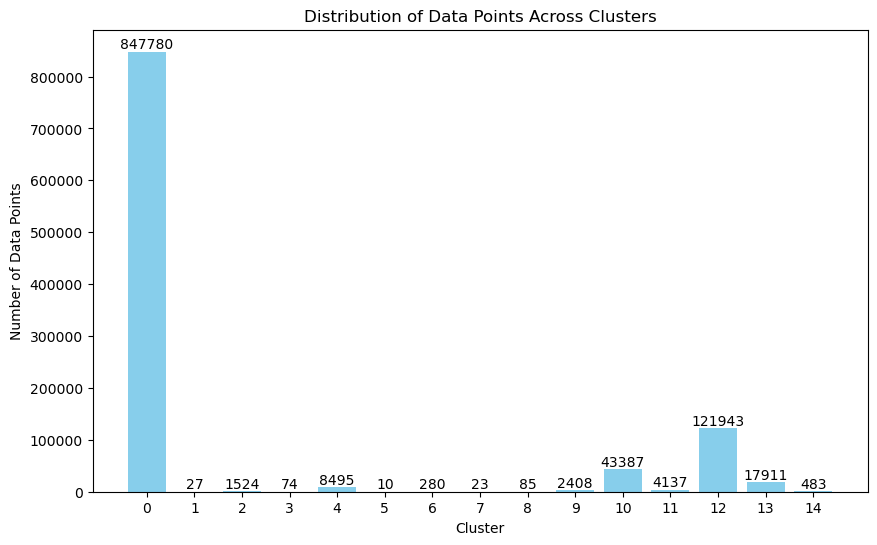

In [31]:
# Graph of our clusters
cluster_counts = merged_data_with_pca['Cluster'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points Across Clusters')
plt.xticks(cluster_counts.index)
for i, count in enumerate(cluster_counts.values):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')
plt.show()

# Given we have a dataset with mostly low transaction amounts, account balances (and only single transaction for each customer), it makes sense that
# most rows fall into cluster zero. Cluster zero is low account balance combined with low total spent. The other clusters likely are high account 
# balances, high transaction amounts, a combination of both and high/low age values. We can investigate further the effect of variables on cluster 
# selection by evaluating correlation between the clustering variables; and looking at aggregate values for each cluster.

In [41]:
# Let's look at aggregate values for our clusters since it's a simple approach
merged_data_with_pca.head()

,CustGender,CustLocation,CustAccountBalance,Age,TotalSpent,NumTransactions,AgeGroup,PC1,PC2,Cluster
0,F,NOIDA,"32,500.73",25,"4,750.00",1,18-24,0.48,0.48,0
1,M,NEW DELHI,"120,180.54",34,356.00,1,60+,-0.18,0.34,12
2,M,MUMBAI,"24,204.49",23,"1,499.00",1,18-24,-0.01,0.48,0
3,F,MUMBAI,"38,377.14",26,"1,205.00",1,35-45,-0.05,0.88,0
4,M,MUMBAI,"161,848.76",33,250.00,1,25-34,-0.20,-0.49,12


In [43]:
# Group by Cluster and calculate aggregate statistics
cluster_stats = merged_data_with_pca.groupby('Cluster').agg({
    'CustGender': lambda x: x.value_counts().to_dict(),  # Count of genders
    'CustLocation': lambda x: x.value_counts().to_dict(),  # Count of locations
    'Age': ['min', 'max', 'mean'],  # Minimum, maximum, and mean age
    'TotalSpent': 'mean',  # Average total spent
    'PC1': 'mean',  # Average PC1
    'PC2': 'mean'  # Average PC2
})

# Rename columns for better interpretation
cluster_stats.columns = ['Gender_Count', 'Location_Count', 'Min_Age', 'Max_Age', 'Avg_Age', 'Avg_TotalSpent', 'Avg_PC1', 'Avg_PC2']

# Display the aggregate statistics for each cluster
cluster_stats

,Gender_Count,Location_Count,Min_Age,Max_Age,Avg_Age,Avg_TotalSpent,Avg_PC1,Avg_PC2
Cluster,,,,,,,,
0,"{'M': 624338, 'F': 223441, 'T': 1}","{'MUMBAI': 77552, 'BANGALORE': 66807, 'NEW DEL...",7,106,31.54,"1,226.28",-0.05,-0.00
1,"{'M': 26, 'F': 1}","{'GURGAON': 13, 'HYDERABAD': 12, 'MUMBAI': 1, ...",19,64,47.89,"35,259.20",5.12,-0.08
2,"{'M': 1200, 'F': 324}","{'NEW DELHI': 258, 'MUMBAI': 244, 'GURGAON': 1...",19,94,41.33,"5,718.70",0.63,0.02
3,"{'M': 68, 'F': 6}","{'MUMBAI': 15, 'PO BOX 28483 DUBAI': 12, 'GURG...",27,69,43.97,"4,510.14",0.45,0.01
4,"{'M': 6423, 'F': 2072}","{'NEW DELHI': 1486, 'MUMBAI': 1234, 'GURGAON':...",19,97,38.83,"4,240.34",0.41,-0.00
5,{'M': 10},{'SHILLONG': 10},50,50,50.00,"6,391.73",0.73,-0.12
6,"{'M': 224, 'F': 56}","{'KOLKATA': 55, 'MUMBAI': 41, 'GURGAON': 25, '...",19,71,41.06,"6,946.06",0.82,0.01
7,"{'F': 19, 'M': 4}","{'GURGAON': 19, 'TIRUPUR': 4}",54,86,80.43,"14,872.84",2.02,-0.14
8,"{'M': 74, 'F': 11}","{'NEW DELHI': 60, 'DELHI': 9, 'MOHALI': 5, 'BA...",36,68,59.20,"7,403.80",0.89,0.02


In [ ]:
# Some observations regarding the our clusters

# We can also decide on some arbitrary customer tiers here (t1 to t5, increasing tiers according to spending potential per person)

# Cluster 0: low average age and people from big cities. Low spending. 847k people (majority of customers-t1)
# Cluster 1: High spenders, moderate average age. Only 27 people. (t5)
# Cluster 4: Moderate average age and  moderate spending. 8k people. (t3)
# Cluster 7: Moderate to high spenders. higher average age. Only 23 people. (t4)
# Cluster 10: Low to moderate spenders. Low-moderate average age. 43k people. (t2)
# Cluster 12: Quite similar to cluster 10, although leaning more towards t1. (t2)
# Cluster 13: Quite similar to cluster 10, although leaning more towards t3. (t2)
# Cluster 14: Similar to Cluster 4. (t3)

# What could be added in the future

# We can combine our clusters into tiers we decided and do further analysis
# We can look at what time of day customers in each tier do their transactions
# We can look at what day of week customers in each tier do their transactions